In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
from pathlib import Path
import tarfile
from io import StringIO
import xarray as xr
import xrft
import pyproj
import pygmt
import euler

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
data_path = Path('../data/rio-magnetic.nc')
data = xr.open_dataset(data_path, engine='netcdf4')
coordinates = [data.easting_m.values, data.northing_m.values, data.height_m.values]
data

<xarray.Dataset> Size: 9MB
Dimensions:     (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m   (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m  (northing_m) float64 6kB -2.373e+06 -2.372e+06 ... -2.295e+06
    height_m    (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nT      (northing_m, easting_m) float64 4MB ...

## Calculate the derivatives using Fourier Transforms

In [3]:
data["deriv_east"] = hm.derivative_easting(data.tfa_nT)
data["deriv_north"] = hm.derivative_northing(data.tfa_nT)

magnetic_grid_no_height = data.drop_vars("height_m")
pad_width = {
    "easting_m": data.easting_m.size // 3,
    "northing_m": data.northing_m.size // 3,
}
padded = xrft.pad(
    magnetic_grid_no_height.tfa_nT, pad_width, mode="linear_ramp", constant_values=None
)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
data = data.assign(
    total_gradient=np.sqrt(data.deriv_east**2 + data.deriv_north**2 + data.deriv_up**2)
)
data

<xarray.Dataset> Size: 27MB
Dimensions:         (northing_m: 776, easting_m: 723)
Coordinates:
  * easting_m       (easting_m) float64 6kB -4.398e+06 -4.398e+06 ... -4.326e+06
  * northing_m      (northing_m) float64 6kB -2.373e+06 ... -2.295e+06
    height_m        (northing_m, easting_m) float64 4MB 300.0 300.0 ... 300.0
Data variables:
    tfa_nT          (northing_m, easting_m) float64 4MB 153.7 154.9 ... 123.8
    deriv_east      (northing_m, easting_m) float64 4MB 0.01172 ... -0.02336
    deriv_north     (northing_m, easting_m) float64 4MB 0.009082 ... 0.01421
    deriv_up        (northing_m, easting_m) float64 4MB -0.01014 ... -0.02335
    total_gradient  (northing_m, easting_m) float64 4MB 0.01796 ... 0.03595

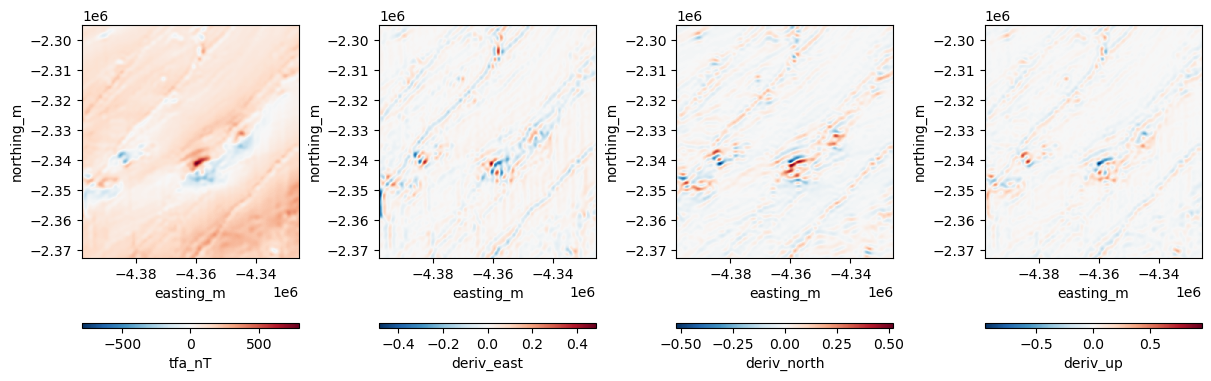

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["tfa_nT", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Euler Deconvolution

In [9]:
window_size = 10e3
window_step = window_size / 4

In [10]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.3,
    ).fit_grid(
        data,
        data_names=("tfa_nT", "deriv_east", "deriv_north", "deriv_up"),
        coordinate_names=("easting_m", "northing_m", "height_m"),
    )

CPU times: user 17.2 s, sys: 274 ms, total: 17.5 s
Wall time: 17.5 s


## Euler Inversion

In [11]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.10,
).fit_grid(
    data,
    data_names=("tfa_nT", "deriv_east", "deriv_north", "deriv_up"),
    coordinate_names=("easting_m", "northing_m", "height_m"),
)

CPU times: user 2.83 s, sys: 512 ms, total: 3.34 s
Wall time: 3min 17s


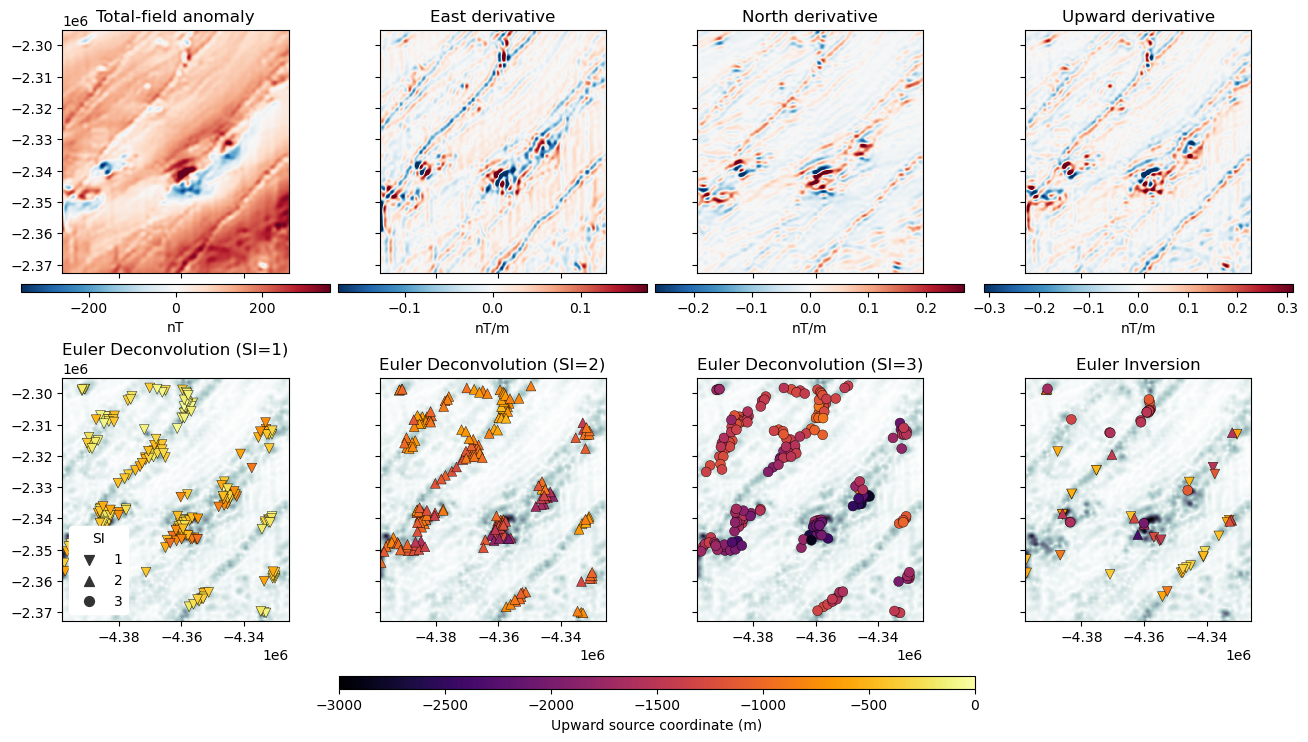

In [12]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nT": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nT": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


for field, ax in zip(["tfa_nT", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(data[field].values, 99.8)
    tmp = data[field].plot.pcolormesh(
        ax=ax,
        add_colorbar=False,
        add_labels=False,
        vmax=scale,
        vmin=-scale,
        cmap="RdBu_r",
    )
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(data.total_gradient.values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    data.total_gradient.plot.pcolormesh(
        ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        # cmap="tab20b",
        cmap="inferno",
    )

# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        # cmap="tab20b",
        cmap="inferno",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")